# Project - 3: Neural NetWork in Python

# Huy Huynh

# DATA 4319

A neural network is an oriented graph. It consists of nodes which in the biological analogy represent neurons, connected by arcs. It corresponds to dendrites and synapses. Each arc associated with a weight while at each node. Apply the values received as input by the node and define Activation function along the incoming arcs, adjusted by the weights of the arcs.

A neural network is a machine learning algorithm based on the model of a human neuron. The human brain consists of millions of neurons. It sends and process signals in the form of electrical and chemical signals. These neurons are connected with a special structure known as synapses. Synapses allow neurons to pass signals. From large numbers of simulated neurons neural networks forms.

![1](https://data-flair.training/blogs/wp-content/uploads/sites/2/2019/07/Introduction-to-Artificial-Neural-Networks.jpg)

Neural networks find great application in data mining used in sectors. For example economics, forensics, etc and for pattern recognition. It can be also used for data classification in a large amount of data after careful training.

A neural network may contain the following 3 layers:

   - Input layer – The activity of the input units represents the raw information that can feed into the network.
   - Hidden layer – To determine the activity of each hidden unit. The activities of the input units and the weights on the connections between the input and the hidden units. There may be one or more hidden layers.
   - Output layer – The behavior of the output units depends on the activity of the hidden units and the weights between the hidden and output units

In [1]:
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
import cv2
import os
from PIL import Image

In [2]:
def initialize_parameters_he(layer_dims):
    parameters = {}
    num_layers = len(layer_dims)

    for l in range(1, num_layers):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l],layer_dims[l-1])*np.sqrt(1/layer_dims[l - 1])
        parameters['b' + str(l)] = np.zeros((layer_dims[l],1)) * np.sqrt(1. /layer_dims[l - 1])
    
    return parameters

def initialize_velocity_momentum(parameters):
    v = {}
    
    num_layers = len(parameters) // 2  

    for i in range(1, num_layers + 1):
        v["dw" + str(i)] = np.zeros((parameters["W" + str(i)].shape[0], parameters["W" + str(i)].shape[1]))
        v["db" + str(i)] = np.zeros((parameters["b" + str(i)].shape[0], parameters["b" + str(i)].shape[1]))
        

    return v

def linear_forward(a, w, b):
    z = np.dot(w,a) + b
    cache = (a, w, b)

    return z, cache

def sigmoid(z):
    a = 1/(1 + np.exp(-1*z))
    activation_cache = {"Z": z}

    return a, activation_cache

def linear_activation_forward(a_prev, w, b):

    z, linear_cache = linear_forward(a_prev, w, b)
    a, activation_cache = sigmoid(z)

    cache = (linear_cache, activation_cache)

    return a, cache

def L_model_forward(x, parameters):
    cache_main = []
    a = x
    num_layers = len(parameters) // 2

    for l in range(1,num_layers+1):
        a_prev = a
        a, cache_temp = linear_activation_forward(a_prev, parameters["W" + str(l)],parameters["b" + str(l)])
        cache_main.append(cache_temp)

    return a, cache_main

def compute_cost_with_L2(al, y, parameters, lambd):

    m = y.shape[1]  
    parameters_sum = []
    num_layers = len(parameters) // 2

    cross_entropy_cost = (-1/m)*( np.sum( y*np.log(al) ) + np.sum( (1 - y)*np.log(1 - al) ) )

    return cross_entropy_cost


def compute_cost(al, y, parameters, lambd):
    cost = compute_cost_with_L2(al, y, parameters, lambd)
    return cost

def sigmoid_backward(da, activation_cache):
    # Since dz = da * g'(z)
    z = activation_cache["Z"]
    a = 1/(1 + np.exp(-1 * z))
    
    dz = np.multiply(da, a*(1 - a))
    return dz

def linear_backward(dz, cache, lambd):

    a_prev, w, b = cache
    m = a_prev.shape[1]

    dw = (1/m)*(np.dot(dz,a_prev.T)) + (lambd/m)*w
    db = (1/m)*(np.sum(dz, axis = 1, keepdims = True))
    da_prev = np.dot(w.T,dz)

    return da_prev, dw, db

def linear_activation_backward(da, cache, lambd):

    linear_cache, activation_cache = cache

    dz = sigmoid_backward(da, activation_cache)
    da_prev, dw, db = linear_backward(dz, linear_cache, lambd)
        
    return da_prev, dw, db

def L_model_backward(al, y, caches, lambd):
    grads = {}
    num_layers = len(caches)

    m = al.shape[1]
    y = y.reshape(al.shape)

    dal = - (np.divide(y, al) - np.divide(1 - y, 1 - al))

    current_cache = caches[num_layers - 1]
    linear_cache, activation_cache = current_cache

    grads["dA" + str(num_layers)], grads["dW" + str(num_layers)], grads["db" + str(num_layers)] =linear_activation_backward(dal, current_cache, lambd)

    for l in reversed(range(num_layers - 1)):
        current_cache = caches[l]

        da_prev_temp, dw_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 2)], current_cache,lambd)

        grads["dA" + str(l + 1)] = da_prev_temp
        grads["dW" + str(l + 1)] = dw_temp
        grads["db" + str(l + 1)] = db_temp

    return grads

def update_parameters_with_momentum(parameters, grads, learning_rate, v, beta):
    num_layers = len(parameters) // 2

    for l in range(1, num_layers + 1):
        v["dw" + str(l)] = beta*v["dw" + str(l)] + (1 - beta)*grads["dW" + str(l)]
        v["db" + str(l)] = beta*v["db" + str(l)] + (1 - beta)*grads["db" + str(l)]
        parameters["W" + str(l)] -= (learning_rate * v["dw" + str(l)])
        parameters["b" + str(l)] -= (learning_rate * v["db" + str(l)])

    return parameters, v

In [3]:
def random_mini_batches(x, y, mini_batch_size = 128, seed = 0):
    np.random.seed(seed)

    m = x.shape[1]  
    mini_batches = []
    permutation = list(np.random.permutation(m))
    shuffled_x = x[ :, permutation]
    shuffled_y = y[ :, permutation]

    batches =  -(-m // mini_batch_size)
    for j in range(batches):

        begin = j * mini_batch_size
        end = min(begin + mini_batch_size, X_train.shape[1] - 1)
        mini_batch_x = shuffled_x[:, begin:end]
        mini_batch_y = shuffled_y[:, begin:end]
        mini_batch = (mini_batch_x, mini_batch_y)
        mini_batches.append(mini_batch)

    return mini_batches

In [64]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import seaborn as sns

def predict_train_accuracy(train_x, train_y, parameters):
    al = L_model_forward(train_x, parameters)[0]
    
    predictions = np.argmax(al, axis=0)
    labels = np.argmax(train_y, axis=0)

    #print(classification_report(predictions, labels))
    return accuracy_score(labels,predictions)

def show_confuse_matrix(train_x, train_y, parameters):
    al = L_model_forward(train_x, parameters)[0]
    
    predictions = np.argmax(al, axis=0)
    labels = np.argmax(train_y, axis=0)

    cf_matrix = confusion_matrix(predictions, labels)
    #print(cf_matrix) 
    
    plt.figure(figsize=(10, 6))
    
    ax= sns.heatmap(cf_matrix, annot=True,cmap="OrRd",fmt='',) #fix bug display confusion matrix
    ax.set_ylim(10.0, 0)
    plt.title('Confusion Matrix', fontsize = 20) 
    plt.xlabel('Predicted Label', fontsize = 15) 
    plt.ylabel('True Label', fontsize = 15) 

In [18]:
def L_layer_model(x, y, layer_dims, learning_rate, epochs, print_cost, batch_size):
    costs = []
    seed = 10
    lambd = 0.3  # regularization parameter

    parameters = initialize_parameters_he(layer_dims)
    v = initialize_velocity_momentum(parameters)

    for i in range(1, epochs+1):
        seed += 1
        minibatches = random_mini_batches(x, y, batch_size, seed)
        for minibatch in minibatches:
            minibatch_x, minibatch_y = minibatch

            # A single forward pass
            al, caches = L_model_forward(minibatch_x, parameters)

            # Cost computing
            cost = compute_cost(al, minibatch_y, parameters, lambd)

            # Backward Pass
            grads = L_model_backward(al, minibatch_y, caches, lambd)

            # Update parameters
            parameters, v = update_parameters_with_momentum(parameters, grads, learning_rate, v, 0.9)

        if print_cost and i % 10 is 0:
            print("accuracy score after epoch %i: %f" % (i, predict_train_accuracy(x, y, parameters)))
            print("=============")
    

    return parameters

In [6]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
X,y=mnist["data"],mnist["target"]

# scale
X = X / 255

# one-hot encode labels
digits = 10
examples = y.shape[0]
y = y.reshape(1, examples)
Y_new = np.eye(digits)[y.astype('int32')]
Y_new = Y_new.T.reshape(digits, examples)

# split, reshape, shuffle
m = 60000
m_test = X.shape[0] - m
X_train, X_test = X[:m].T, X[m:].T
Y_train, Y_test = Y_new[:,:m], Y_new[:,m:]
shuffle_index = np.random.permutation(m)
X_train, Y_train = X_train[:, shuffle_index], Y_train[:, shuffle_index]

In [7]:
print(np.shape(X_train))
print(np.shape(Y_train))

(784, 60000)
(10, 60000)


In [19]:
layer_dims = [784, 200,100,50, 10]

parameters = L_layer_model(X_train, Y_train, layer_dims, 0.5, 100, True, 256)

accuracy score after epoch 10: 0.921867
accuracy score after epoch 20: 0.946300
accuracy score after epoch 30: 0.953100
accuracy score after epoch 40: 0.957417
accuracy score after epoch 50: 0.959500
accuracy score after epoch 60: 0.961433
accuracy score after epoch 70: 0.962100
accuracy score after epoch 80: 0.961050
accuracy score after epoch 90: 0.962317
accuracy score after epoch 100: 0.962867


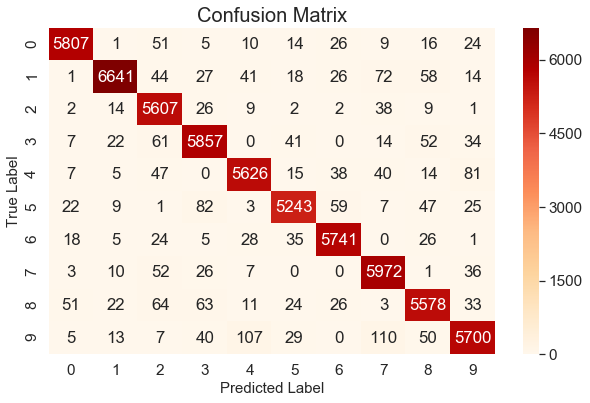

In [65]:
show_confuse_matrix(X_train, Y_train, parameters)

In [66]:
predict_train_accuracy(X_test, Y_test, parameters)

0.9595

In [67]:
X_test[:,5].shape

(784,)

In [68]:
X_test[:,5].reshape(784, 1).shape

(784, 1)

In [69]:
print(len(L_model_forward(X_test[:,5].reshape(784, 1), parameters)[0]))
L_model_forward(X_test[:,5].reshape(784, 1), parameters)[0]

10


array([[2.12019357e-07],
       [9.84301022e-01],
       [3.54022023e-03],
       [3.24372468e-03],
       [8.28961738e-03],
       [3.02211021e-03],
       [8.24275788e-04],
       [2.33992250e-02],
       [2.08130239e-03],
       [1.09066704e-03]])

In [70]:
print(np.argmax(L_model_forward(X_test[:,5].reshape(784, 1), parameters)[0]))
print(np.argmax(Y_test[:,5],axis=0))

1
1


In [75]:
def predict_number(x,parameters):
    return np.argmax(L_model_forward(x.reshape(784, 1), parameters)[0])
def check_predict(x, y, i,parameters):
    print("Predicted number is %i and Actual number is %i" %(predict_number(x[:,i], parameters),
                                                             np.argmax(y[:,i],axis=0)))

# We pick ramdomly number to test model

Predicted number is 3 and Actual number is 3


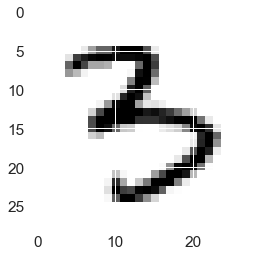

In [78]:
random=np.random.randint(0,10000,1).item()
check_predict(X_test, Y_test, random,parameters)
plt.imshow(X_test[:,random].reshape(28,28), cmap = matplotlib.cm.binary)

Predicted number is 6 and Actual number is 6


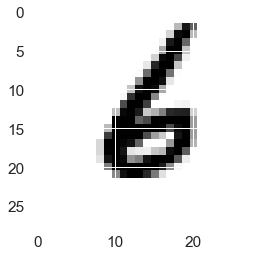

In [79]:
random=np.random.randint(0,10000,1).item()
check_predict(X_test, Y_test, random,parameters)
plt.imshow(X_test[:,random].reshape(28,28), cmap = matplotlib.cm.binary)

Predicted number is 7 and Actual number is 7


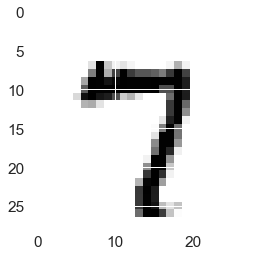

In [80]:
random=np.random.randint(0,10000,1).item()
check_predict(X_test, Y_test, random,parameters)
plt.imshow(X_test[:,random].reshape(28,28), cmap = matplotlib.cm.binary)